<a href="https://colab.research.google.com/github/Moin000/Certification/blob/master/A_B_Test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# prompt: read another file in the sale pricing_test folder but the file name is user_table.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
from matplotlib import rcParams
from pathlib import Path
rcParams.update({'figure.autolayout': True})
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

test = pd.read_csv("/content/test_results.csv")
print(test.head())

user = pd.read_csv("/content/user_table.csv")
print(user.head())


   user_id            timestamp          source  device operative_system  test  price  converted
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS     0     39          0
1   624057  2015-05-10 21:08:46      seo-google  mobile          android     0     39          0
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android     0     39          0
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS     1     59          0
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac     0     39          0
   user_id         city country    lat    long
0   510335      Peabody     USA  42.53  -70.97
1    89568         Reno     USA  39.54 -119.82
2   434134       Rialto     USA  34.11 -117.39
3   289769  Carson City     USA  39.15 -119.74
4   939586      Chicago     USA  41.84  -87.68


In [5]:
print(test.isnull().sum())

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64


In [6]:
print(user.isnull().sum())

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64


In [7]:
#join the two datasets on user_id
data=pd.merge(left=test, right=user, how='left', on='user_id')
print(data.head())


   user_id            timestamp          source  device operative_system  ...  converted          city  country    lat   long
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS  ...          0       Buffalo      USA  42.89 -78.86
1   624057  2015-05-10 21:08:46      seo-google  mobile          android  ...          0     Lakeville      USA  44.68 -93.24
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android  ...          0         Parma      USA  41.38 -81.73
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS  ...          0  Fayetteville      USA  35.07 -78.90
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac  ...          0       Fishers      USA  39.95 -86.02

[5 rows x 12 columns]


In [8]:
#check missing values. Since there were no missing values before the join,
#this would mean some users are in the test table, but not in the user table
print(data.isnull().sum())


user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64


In [9]:
#let's check if, in fact, those missing values are exactly the number of rows
#in the test table - user table
print(max(data.isnull().sum())==(test.shape[0]-user.shape[0]))


True


In [10]:
print(data[['user_id','test','price']].groupby(['test','price']).count())

            user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918


In [11]:
data=data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]
print(data[['user_id','test','price']].groupby(['test','price']).count())


            user_id
test price         
0    39      202517
1    59      113918


In [12]:
#Let's now create the revenue variable, which is the main target of this challenge
data['revenue']=data['converted']*data['price']

print(data['revenue'].describe())

count    316435.000000
mean          0.827083
std           6.179009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: revenue, dtype: float64


In [13]:
#Q: Should the company sell its software for 39 or 59?
#Firstly let's compare conversion rate.
#We obviously do expect convesion rate to drop, let's check by how much
print(data[['converted','test']].groupby('test').mean())

      converted
test           
0      0.019900
1      0.015555


In [14]:
#Check avg revenue per user
print(data[['revenue','test']].groupby('test').mean())


       revenue
test          
0     0.776083
1     0.917748


In [15]:
#Yes, it looks like revenue per user is up. Let’s now check if this is statistically significant:
#Check avg revenue per user
print(ttest_ind(data[data['test']==1]['revenue'], data[data['test']==0]['revenue'], equal_var=False))

TtestResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08, df=186141.738219264)


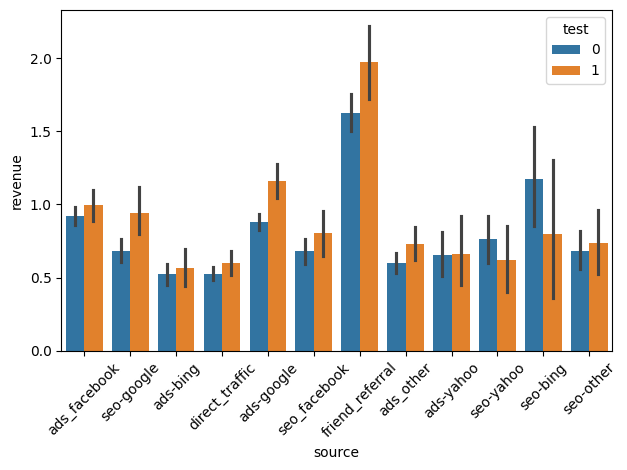

In [16]:
#how much different users are valuing our product?
sns.barplot(x='source', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()


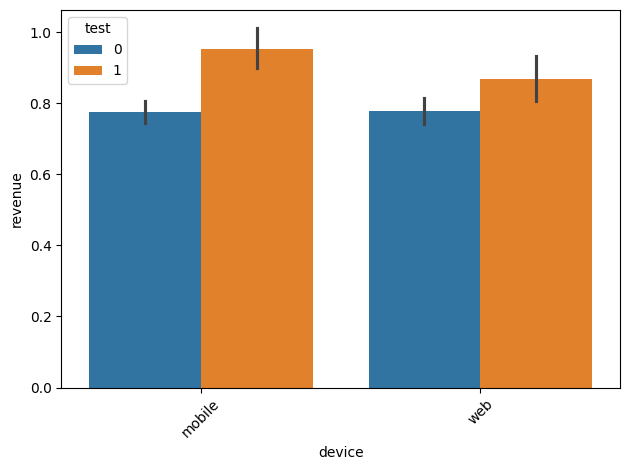

In [17]:
sns.barplot(x='device', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)
plt.show()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'iOS'),
  Text(1, 0, 'android'),
  Text(2, 0, 'mac'),
  Text(3, 0, 'windows'),
  Text(4, 0, 'other'),
  Text(5, 0, 'linux')])

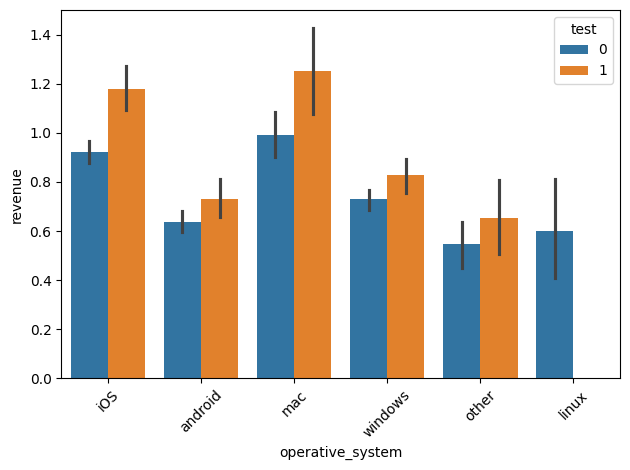

In [18]:
sns.barplot(x='operative_system', y='revenue', hue='test', data=data)
plt.xticks(rotation=45)


In [19]:
#Firstly, how many users are we talking about?
print(data.query('operative_system==\'linux\'').shape[0]/data.shape[0])


0.01305165357814401


In [20]:
#Check avg revenue per user after removing Linux
data = data.query('operative_system!=\'linux\'')
print(data[['revenue','test']].groupby('test').mean())


       revenue
test          
0     0.778002
1     0.933531


In [21]:
print(ttest_ind(data.query('test==1')['revenue'], data.query('test==0')['revenue'], equal_var=False))

TtestResult(statistic=6.184240028400434, pvalue=6.253458285742887e-10, df=181667.22654265029)


In [56]:
# prompt: print count of column city from data in descending order with count, and write top 10 count cities also set row number column from 0-9 name the column index


top_cities = data['city'].value_counts().reset_index().head(10)
top_cities.columns = ['index', 'city']
print(top_cities)



          index   city
0      New York  25401
1       Chicago   7071
2       Houston   6608
3   San Antonio   4554
4   Los Angeles   4089
5      San Jose   3312
6  Indianapolis   3177
7  Jacksonville   2865
8  Philadelphia   2488
9     Las Vegas   2375


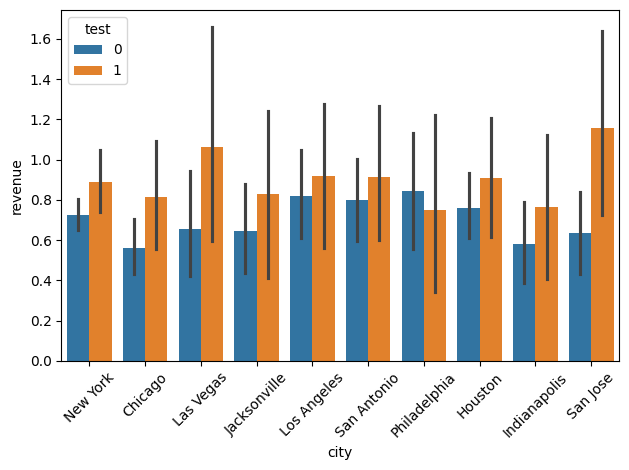

In [57]:
#plot avg revenue for top 10 cities
sns.barplot(x='city', y='revenue', hue='test', data=data[data['city'].isin(top_cities['index'])])
plt.xticks(rotation=45)
plt.show()

In [59]:
# prompt: #After how many days you would have stopped the test?

conversion_rate_control = test.query('test==0').converted.mean()
p1_and_p2 = sms.proportion_effectsize(conversion_rate_control, conversion_rate_control*39/59)
sample_size = round(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
print("The required sample size per group is ~", sample_size)



The required sample size per group is ~ 5548


In [60]:
#create a column that's week of the year
test['week_year'] = pd.to_datetime(test.timestamp.str.split(' ').str[0]).dt.strftime('%W')
#take avg count of users per week. We remove first and last week, just in case they don't include all 7 days
users_week = test['week_year'].value_counts().sort_index()
users_week = users_week.drop(users_week.index[[0,(users_week.shape[0]-1)]]).mean()

print("Avg number of users per week is:", round(users_week))


Avg number of users per week is: 24356


In [61]:
print("The percentage of traffic that needs to be in test is", round(sample_size/(users_week*2)*100))

The percentage of traffic that needs to be in test is 11
